# Tutorial II: Image Classification
###Acknowledgment
1.   This tutorial was prepared by Najee Stubbs at the University of Arkansas (nistubbs@uark.edu) and revised following comments from Joss Knight (jknight@mathworks.com).
2.   The development of this tutorial was supported by a gift from MathWorks through the MathWorks Curriculum Development Support program.
3.   The dataset and algorithms used in this tutorial are from C. Dunlap, H. Pandey, and H. Hu, “Supervised and Unsupervised Learning Models for Detection of Critical Heat Flux During Pool Boiling,” in Proceedings of the ASME 2022 heat Transfer Summer Conference, HT2022-85582. [[link](https://asmedigitalcollection.asme.org/HT/proceedings/HT2022/85796/V001T08A004/1146566)]
4.   This tutorial was implemented in MEEG tech elective "Machine Learning for Mechanical Engineers." [[link](https://ned3.uark.edu/teaching/)]

#### 1. Import Libraries

In [ ]:
!pip install split-folders

In [ ]:
import os
import cv2
import time
import numpy as np
import splitfolders
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

#### 2. Load and Process Data - Separate into Training, Validation, and Testing Datasets, Verify Data

In [ ]:
# directory procedure for google colab only
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
input_folder = '/content/drive/My Drive/Colab Notebooks/ImageDataset/'
output_folder = "Lecture_Dataset_2"

In [ ]:
splitfolders.ratio(input_folder, output=output_folder,
                   seed=42, ratio=(.7,.2,.1),
                   group_prefix=None)

Copying files: 3000 files [01:15, 39.97 files/s] 


In [ ]:
# Dynamically generate the directories based on the output folder
train_dir = f'{output_folder}/train'
val_dir = f'{output_folder}/val'
test_dir = f'{output_folder}/test'

img_height, img_width = 80, 128

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, color_mode='grayscale',
    image_size=(img_height, img_width), label_mode='categorical')

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir, color_mode='grayscale',
    image_size=(img_height, img_width), label_mode='categorical')

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, color_mode='grayscale',
    image_size=(img_height, img_width), label_mode='categorical')

Found 2100 files belonging to 2 classes.
Found 600 files belonging to 2 classes.
Found 300 files belonging to 2 classes.


#### 3. Define Class to Obtain Training Time, and Plot Training Time Vs. Epoch

In [ ]:
class TrainingPerformance(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []
        self.total_time_start = time.time()

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

    def on_train_end(self, logs={}):
        self.total_training_time = time.time() - self.total_time_start
        print("Total training time: {:.2f} seconds".format(self.total_training_time))

        plt.figure(figsize=(10,5))
        plt.plot(range(1, len(self.times) + 1), self.times)
        plt.title('Training time vs number of epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Training time (s)')
        plt.show()

#### 4. Define Function to Create Relevant Post-Training Plots (Loss & Accuracy Curves)

In [ ]:
def training_performance_curves(training_history):
    plt.figure(figsize=(10,5))

    plt.subplot(1, 2, 1)
    plt.title('Loss Curves')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('Accuracy Curves')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

#### 5. Define Variable to Setup Early Stopping Callback for Monitoring the Model Training Progress

In [ ]:
Monitor = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                           min_delta=0.001,
                                           patience=5,
                                           verbose=1,
                                           mode='auto',
                                           restore_best_weights=True)

#### 6. Define Function to Plot Prediction Metrics of the Calssification Model

In [ ]:
def plot_prediction_metrics(y_true, y_pred, train_ds):
    correct_labels = tf.concat([item for item in y_true], axis = 0)
    predicted_labels = tf.concat([item for item in y_pred], axis = 0)

    correct_labels = np.argmax(correct_labels.numpy(), axis=-1)
    predicted_labels = np.array(predicted_labels)
    class_names = train_ds.class_names

    cm = confusion_matrix(correct_labels, predicted_labels)
    plt.figure(figsize=(7,7))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

    print(classification_report(correct_labels, predicted_labels))

    fpr, tpr, _ = roc_curve(correct_labels, predicted_labels)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

#### 7. Define and Build Classification Model

In [ ]:
CNNmodel = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 1)),

    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),

    tf.keras.layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Conv2D(32, (3, 3), padding='same', strides=2, kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2, strides=2),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same', strides=2, kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2, strides=2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='softmax')],
    name='CNN_Model')

CNNmodel.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                 metrics=['accuracy'])

CNNmodel.summary()

Model: "CNN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 80, 128, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 80, 128, 32)       320       
                                                                 
 batch_normalization (Batch  (None, 80, 128, 32)       128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 80, 128, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 64, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 40, 64, 32)        128       
 chNormalization)                                        

#### 8. Train Classification Model

Epoch 1/5
66/66 [==============================] - 57s 800ms/step - loss: 0.6692 - accuracy: 0.7343 - val_loss: 1.0010 - val_accuracy: 0.5000
Epoch 2/5
66/66 [==============================] - 52s 754ms/step - loss: 0.1099 - accuracy: 0.9600 - val_loss: 0.6415 - val_accuracy: 0.5000
Epoch 3/5
66/66 [==============================] - 56s 829ms/step - loss: 0.0460 - accuracy: 0.9833 - val_loss: 0.2838 - val_accuracy: 0.9233
Epoch 4/5
66/66 [==============================] - 52s 769ms/step - loss: 0.0236 - accuracy: 0.9943 - val_loss: 0.0892 - val_accuracy: 1.0000
Epoch 5/5
66/66 [==============================] - 52s 756ms/step - loss: 0.0170 - accuracy: 0.9967 - val_loss: 0.0192 - val_accuracy: 1.0000
Total training time: 326.85 seconds


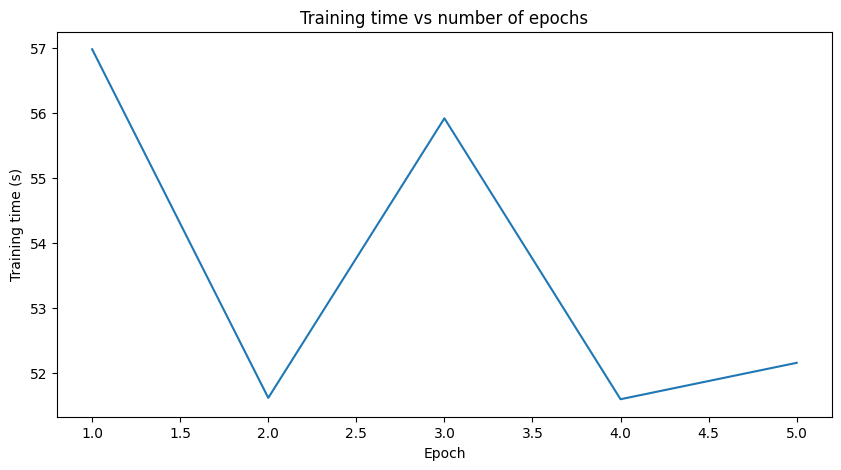

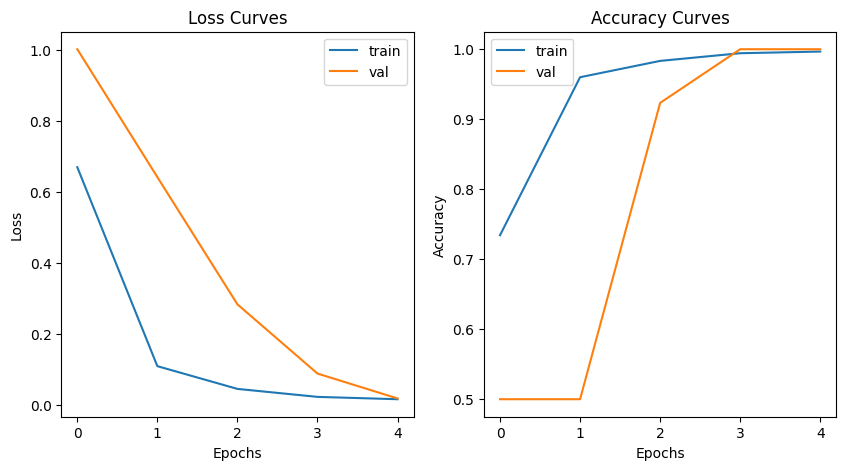

In [ ]:
history= CNNmodel.fit(train_ds,
                      validation_data=val_ds,
                      epochs=5,
                      batch_size=256,
                      verbose=1,
                      callbacks=[TrainingPerformance(), Monitor])

training_performance_curves(history)

#### 9. Evaluate the Classification Model

In [ ]:
testResults = CNNmodel.evaluate(test_ds, batch_size=128, verbose=0)
print(f'Test results: {CNNmodel.metrics_names[0]} of {testResults[0]}; {CNNmodel.metrics_names[1]} of {testResults[1]}')

Test results: loss of 0.020205894485116005; accuracy of 1.0


#### 10. Test the Classification Model

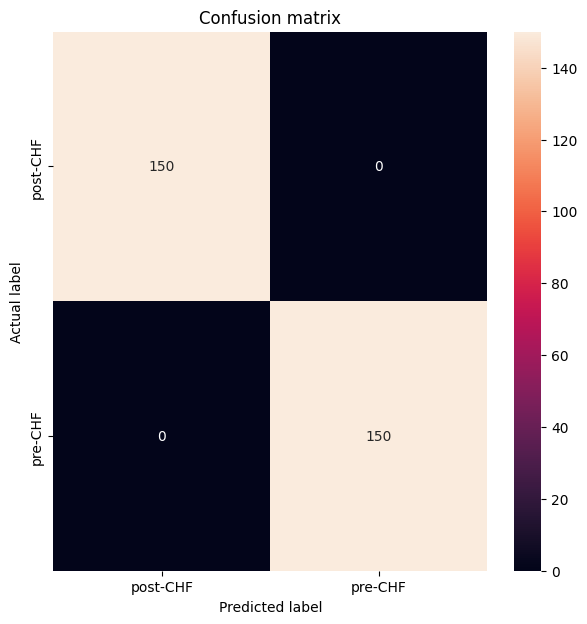

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       150
           1       1.00      1.00      1.00       150

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



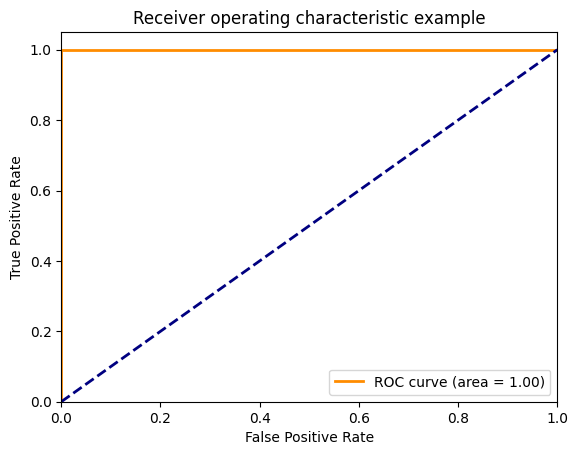

In [ ]:
y_pred = []
y_true = []

for image_batch, label_batch in test_ds:
    y_true.append(label_batch)
    preds = CNNmodel.predict(image_batch, verbose=0)
    y_pred.append(np.argmax(preds, axis = - 1))

plot_prediction_metrics(y_true, y_pred, train_ds)